# Python version implementation of the paper (FTEX-D-21-00122),

"Support structure tomography using per-pixel signed shadow casting in human manikin 3D printing"

, submitted to Fashion and Textiles .

 ※ You need to upload your manikin mesh file in google drive (use the "folder"-like icon at the left hand side of this window) in advance, and  change the filename of section "3. File Loading". Alsso you can rotate the input mesh by changing the (yaw, pitch, roll) values in section "4. Main Routine", if needed.



#1. Install Open3D package for rendring

(You need to execute this cell only once).

In [ ]:
!pip install open3d  #You need to install "Open3D" package, everytime you visit this page (Google Colab pages are refreshed every 12 hours).

#2. Constants and sub-routines.
(You need to execute this cell only once).

In [ ]:
import numpy  as np             
import open3d as o3d            
import matplotlib.pyplot as plt 
import copy

#constants
alpha_color = ([1., 0., 0.]) #red
beta_color  = ([0., 0., 1.]) #blue
TC_color    = ([0., 1., 0.]) #green
(origin, xaxis, yaxis, zaxis) = ([0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1])
voxel_size  = 1. #do not change this value

#subroutines
def numpyToOpen3D( np_pixels, _color0):
  o3d_pixels        = o3d.geometry.PointCloud() #pixel list to return (for Open3D rendering)
  o3d_pixels.points = o3d.utility.Vector3dVector( np_pixels)
  o3d_pixels.paint_uniform_color( _color0)
  return o3d_pixels

def createZeroPixels(_x0, _y0, _x1, _y1):
  zero_pixels_np = np.zeros( ( _x1-_x0+1, _y1-_y0+1, 3)).astype(np.int32)
  for x in range (0, _x1-_x0+1):
    for y in range(0, _y1-_y0+1):
      zero_pixels_np[x,y,0] = _x0+x;      zero_pixels_np[x,y,1] = _y0+y;
  return zero_pixels_np

def Area2( A,B,C):#assume z-component zero
  return np.cross( B-A, C-A)[2] 
  
def getBoundary( _mesh0):
  v0_np = np.asarray( _mesh0.vertices)
  mesh0_min = [np.min( v0_np[:,0]), np.min( v0_np[:,1]), np.min( v0_np[:,2])]
  mesh0_max = [np.max( v0_np[:,0]), np.max( v0_np[:,1]), np.max( v0_np[:,2])]
  return (mesh0_min,mesh0_max)

def triCoord( _point, _triA, _triB, _triC):#assume z-component zero
  (x,y,z) = _point;   ax, ay, az = _triA;  bx, by, bz = _triB;  cx, cy, cz = _triC;
  area0 = Area2( _triA, _triB, _triC)
  side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
  side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
  side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
  return (side_2 / area0, side_3/area0, side_1/area0)

def triPixel( tri1):
  tri0 = copy.deepcopy(tri1); tri0[:,2]=0;
  mesh1_min = [np.min( tri1[:,0]), np.min( tri1[:,1]), np.min( tri1[:,2])]
  mesh1_max = [np.max( tri1[:,0]), np.max( tri1[:,1]), np.max( tri1[:,2])]
  (x1,y1,z1) = list(map(int, mesh1_max))
  (x0,y0,z0) = list(map(int, mesh1_min))
  x = np.arange( x0, x1+1).astype(np.int32)
  y = np.arange( y0, y1+1).astype(np.int32)
  vox_coord  = np.vstack((np.repeat(x, len(y)), np.tile(y, len(x)))).T.reshape( len(x), len(y), 2) # (integer)
  vox_data =  np.empty((0,3), float)# return data
  for i in range(len(x)):
    for j in range(len(y)):
      v_center =  np.array( [vox_coord[i,j,0] ,vox_coord[i,j,1], 0] )
      (u,v,w) = triCoord( v_center, tri0[0], tri0[1], tri0[2])
      if u > -0.01 and v > -0.01 and w > -0.01:
        h = tri1[0,2] * u + tri1[1,2] * v + tri1[2,2] * w
        vox_data = np.append( vox_data, np.array([[vox_coord[i,j,0],vox_coord[i,j,1],h]]) , axis=0)
  return vox_data

def pixelizeMesh( _mesh0,_color0):
  vtx_np = np.asarray( _mesh0.vertices)
  ele_np = np.asarray( _mesh0.triangles)
  pixels_np = np.empty((0,3), float)
  for ele in ele_np:
    tri = np.array([vtx_np[ele[0]], vtx_np[ele[1]], vtx_np[ele[2]] ])
    pixels_np = np.append( pixels_np, triPixel( tri), axis=0)
  pixels_o3d = numpyToOpen3D( pixels_np, _color0 )
  return ( pixels_np, pixels_o3d)

def selectiveMeshCopy(_mesh0, _bMaskList, _color):
  mesh1 = copy.deepcopy(_mesh0)
  mesh1.triangles        = o3d.utility.Vector3iVector( np.asarray( _mesh0.triangles)[ _bMaskList] )
  mesh1.triangle_normals = o3d.utility.Vector3dVector( np.asarray( _mesh0.triangle_normals)[ _bMaskList] )
  mesh1.paint_uniform_color( _color)
  return mesh1

def createTopCoverPixels( _mapToAdd0, _x0, _y0, _x1, _y1, _color0):
  tc_pixels_np2d = createZeroPixels( _x0, _y0, _x1, _y1)
  _mapToAdd = np.unique( copy.deepcopy(_mapToAdd0), axis=0) #remove redundant pixels
  for pixel in _mapToAdd:
    (a_x, a_y, a_z) = pixel.astype(np.int32)
    if tc_pixels_np2d[ a_x - x0, a_y - y0, 2] < a_z:
      tc_pixels_np2d[  a_x - x0, a_y - y0, 2] = a_z
  tc_pixelheights_for_plot = [val[:,2] for val in tc_pixels_np2d]
  tc_pixels_np = np.reshape( copy.deepcopy(tc_pixels_np2d), (-1,3)) #change array size for rendering
  tc_pixels_o3d= numpyToOpen3D( tc_pixels_np, _color0 )
  return (tc_pixelheights_for_plot, tc_pixels_np, tc_pixels_o3d) 

def createPlot( _mapToAdd0, _x0, _y0, _x1, _y1):
  pixels_np2d = createZeroPixels( _x0, _y0, _x1, _y1)
  _mapToAdd = np.unique( copy.deepcopy(_mapToAdd0), axis=0) #remove redundant pixels
  for pixel in _mapToAdd:
    (a_x, a_y, a_z) = pixel.astype(np.int32)
    pixels_np2d[  a_x - x0, a_y - y0, 2] += a_z
  pixelheights_for_plot = [val[:,2] for val in pixels_np2d]
  return pixelheights_for_plot

#3. File Loading
The input mesh file is loaded here. The file should have been uploaded.

In [ ]:
filename = 'masha.obj' #You should upload file to Google Drive manually, in advance. Filename is case-sensitive.

# Step 1. open mesh data
print('Loading input mesh data')
mesh0 = o3d.io.read_triangle_mesh(filename)
mesh0 = mesh0.translate( mesh0.get_center() * -1.)
mesh0.compute_vertex_normals()
(mesh0_min, mesh0_max) = getBoundary( mesh0)

Loading input mesh data


#4. Main Routine
To find the optimal orientation, you need to repeat this process for each (yaw, pitch, roll) in 0~360 degree.

In [ ]:
#parameters
(yaw, pitch, roll) = ( np.pi /4., 0, 0) #You can modifiy the orientation angle here, in radian

# Step 2. rotate and move onto bottom plate
mesh1 = copy.deepcopy(mesh0)
R = mesh0.get_rotation_matrix_from_xyz((yaw, pitch, roll))
mesh1.rotate( R, center=(0,0,0))
v_np = np.asarray( mesh1.vertices)
(mesh1_min, mesh1_max) = getBoundary( mesh1)
mesh1 = mesh1.translate( np.asarray(mesh1_min) * -1.)
mesh1.compute_vertex_normals()

v_np = np.asarray( mesh1.vertices)
(mesh1_min, mesh1_max) = getBoundary( mesh1)
(x1,y1,z1) = list(map(int, mesh1_max))
(x0,y0,z0) = list(map(int, mesh1_min))

# Step 3. find alpha, beta, NV, TC pixels
print('Finding alpha, beta, NV pixels')
n_np = np.asarray( mesh1.triangle_normals)
bAlpha = np.dot( n_np, zaxis) >  0.01
bBeta  = np.dot( n_np, zaxis) < -0.01

alpha_mesh_o3d = selectiveMeshCopy( mesh1, bAlpha, alpha_color)
beta_mesh_o3d  = selectiveMeshCopy( mesh1, bBeta,  beta_color)

(alpha_pixels_np, alpha_pixels_o3d)  = pixelizeMesh( alpha_mesh_o3d, alpha_color)
( beta_pixels_np,  beta_pixels_o3d)  = pixelizeMesh(  beta_mesh_o3d, beta_color)

alpha_pixels_np = np.unique( alpha_pixels_np.astype(np.int32), axis=0) #convert to integer, to remove redundant pixels

(TC_plot, TC_pixels_np, TC_pixels_o3d)  = createTopCoverPixels( alpha_pixels_np, x0, y0, x1, y1,  TC_color) 

# Step 4. calculate volume
print("Volume info. for [",filename, "]")
Va  = alpha_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vb  =  beta_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vtc =    TC_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vo  = Va - Vb; Vss = - Va + Vb + Vtc ;
print('Va=', Va, ', Vb=', Vb, ', Vtc=', Vtc)
print('Vo=', Vo, ', Vss=', Vss)

Finding alpha, beta, NV pixels
Volume info. for [ masha.obj ]
Va= 301148.0 , Vb= 268535.1939576306 , Vtc= 292523.0
Vo= 32612.806042369397 , Vss= 259910.1939576306


#5-1. Rendering (2D Tomograph)
Final result is shown in 2D tomographs. The darker color means the more filament usage.

Rendering tomographs..


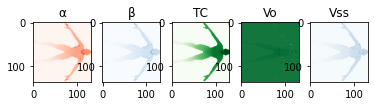

In [ ]:
# Step 5. rendering  tomographs 
print('Rendering tomographs..')
TC_pixels_o3d.translate( np.array([0.1, 0.1, 0.1]))   # give offset for display

alpha_plot = createPlot( alpha_pixels_np, x0, y0, x1, y1)
beta_plot  = createPlot(  beta_pixels_np, x0, y0, x1, y1)
Vo_plot    = (np.array( alpha_plot) - np.array( beta_plot)).tolist()
SS_plot    = (-np.array( alpha_plot) + np.array( beta_plot) + np.array( TC_plot) ).tolist()

plt.subplot(1,5,1);plt.title("α"); plt.imshow(alpha_plot, aspect='equal', cmap=plt.get_cmap('Reds'));
plt.subplot(1,5,2);plt.title("β"); plt.imshow( beta_plot, aspect='equal', cmap=plt.get_cmap('Blues'));
plt.subplot(1,5,3);plt.title("TC"); plt.imshow(   TC_plot, aspect='equal', cmap=plt.get_cmap('Greens'));
plt.subplot(1,5,4);plt.title("Vo"); plt.imshow(   Vo_plot, aspect='equal', cmap=plt.get_cmap('YlGn'));
plt.subplot(1,5,5);plt.title("Vss"); plt.imshow(   SS_plot, aspect='equal', cmap=plt.get_cmap('BuPu'));
plt.show()

#5-2. Rendering (OpenGL 3D)
(Optional) 3D mesh rendering. Note that OpenGL (o3d.visualization) is not supported by Gooogle CoLab yet.Matplotlib was used instead.

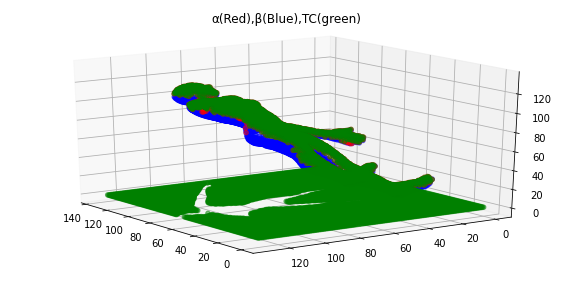

In [ ]:
#step 6. 3D plots 

#o3d.visualization.draw_geometries([alpha_mesh_o3d+beta_mesh_o3d+NV_mesh_o3d])#view triangle mesh
#o3d.visualization.draw_geometries([alpha_pixels_o3d+beta_pixels_o3d+TC_pixels_o3d])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object
ax.view_init(elev=20., azim=145)
ax.scatter( alpha_pixels_np[:,0], alpha_pixels_np[:,1], alpha_pixels_np[:,2], alpha=0.5, color='red')
ax.scatter(  beta_pixels_np[:,0],  beta_pixels_np[:,1],  beta_pixels_np[:,2], alpha=0.5, color='blue')
ax.scatter(    TC_pixels_np[:,0],    TC_pixels_np[:,1],    TC_pixels_np[:,2], alpha=0.5, color='green')
plt.title("α(Red),β(Blue),TC(green)")
plt.show()